## General imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook", font_scale=1.1)


# Data pre-processing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Feature engineering
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer

# modelling specifics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### Common functions

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def print_metrics(y_true, y_pred, data_type):

    print(f"{data_type} PERFORMANCE:")
    print("----------------------")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"R-squared: {r2_score(y_true, y_pred)}\n")
    
# Create an empty dictionary to hold the metrics
metrics_dict = {
    "original features untuned": {"rmse": np.nan, "r2": np.nan},
    "original features tuned": {"rmse": np.nan, "r2": np.nan},
    "all new features": {"rmse": np.nan, "r2": np.nan},
    "Features above > 0.01": {"rmse": np.nan, "r2": np.nan},
    "Features above > 0.02": {"rmse": np.nan, "r2": np.nan},
}

def save_metrics(y_true, y_pred, model_description):
    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Update the global dictionary
    global metrics_dict
    metrics_dict[model_description]["rmse"] = rmse
    metrics_dict[model_description]["r2"] = r2

## Read and view the data

In [6]:
df = pd.read_csv("RFLData.csv")

df.head(3)

,RFL_Att,Temperature,Relative Humidity,Visibility (m),Temperature Difference,Absolute Humidity,Time,Frequency,Distance,Rain Intensity,SYNOP Code
0,4.941875,26.134005,71.820618,66784.84434,13.63,17.672484,9,73500000000,2114.405171,0.0,0
1,4.328734,25.587852,72.885521,71044.74326,-0.54,17.470850,9,73500000000,2121.637684,0.0,0
2,4.356399,25.689856,72.436011,51668.60394,-0.24,17.265145,10,73500000000,2112.868600,0.0,0


## Exploratory data analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111041 entries, 0 to 111040
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   RFL_Att                 111041 non-null  float64
 1   Temperature             111041 non-null  float64
 2   Relative Humidity       111041 non-null  float64
 3   Visibility (m)          111041 non-null  float64
 4   Temperature Difference  111041 non-null  float64
 5   Absolute Humidity       111041 non-null  float64
 6   Time                    111041 non-null  int64  
 7   Frequency               111041 non-null  int64  
 8   Distance                111041 non-null  float64
 9   Rain Intensity          111041 non-null  float64
 10  SYNOP Code              111041 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 9.3 MB


In [8]:
df.describe()

,RFL_Att,Temperature,Relative Humidity,Visibility (m),Temperature Difference,Absolute Humidity,Time,Frequency,Distance,Rain Intensity,SYNOP Code
count,111041.000000,111041.000000,111041.000000,111041.000000,111041.000000,111041.000000,111041.000000,1.110410e+05,111041.000000,111041.000000,111041.000000
mean,12.081390,12.916485,78.788240,29580.656942,-0.108868,10.146837,11.244324,7.850797e+10,3348.651709,0.530645,2.647518
std,4.089316,9.505956,17.514275,24892.579354,0.840872,6.162120,7.000356,5.000016e+09,1208.521498,3.244773,2.935448
min,-0.085651,-6.915637,8.898742,11.181315,-11.157000,1.069317,0.000000,7.350000e+10,2012.000061,0.000000,0.000000
25%,10.794584,4.506938,70.171059,8189.281266,-0.425000,5.080780,5.000000,7.350000e+10,2020.893485,0.000000,0.000000
50%,11.920892,11.060456,83.318654,21737.387580,-0.100000,7.272890,11.000000,8.350000e+10,2961.074365,0.000000,0.000000
75%,13.399258,22.500517,92.286500,47915.829960,0.230000,16.604670,17.000000,8.350000e+10,4820.945766,0.119594,6.000000
max,48.392563,36.734515,99.499857,75004.999240,13.630000,24.985184,23.000000,8.350000e+10,4827.999868,131.801891,8.000000


### Visual distribution using histograms

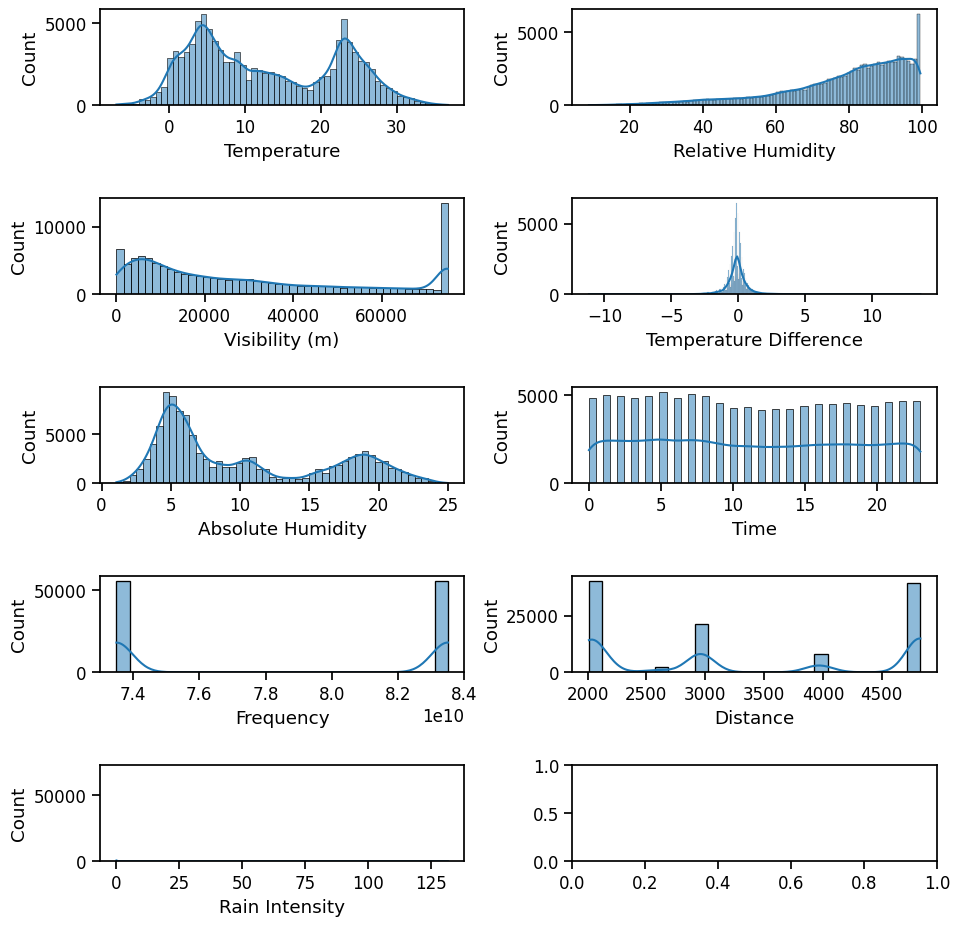

In [13]:
# Define the features to display histograms for
features = ['Temperature', 'Relative Humidity', 'Visibility (m)',
       'Temperature Difference', 'Absolute Humidity', 'Time', 'Frequency',
       'Distance', 'Rain Intensity']

# Create a 5x2 grid of subplots for histograms
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
fig.tight_layout(pad=3.0)  # Adjust the spacing between subplots

# Iterate through the features and plot histograms in each subplot
for i, feature in enumerate(features):
    row = i // 2  # Row index
    col = i % 2   # Column index

    # Plot histogram in the corresponding subplot
    sns.histplot(data=df, x=feature, kde=True, ax=axes[row, col])

# Display the plot
plt.show()

### Data pre-proocessing

In [17]:
# Convert NaN values to a new category for categorical variables
df['SYNOP Code'] = df['SYNOP Code'].fillna('missing').astype(str)

# Define preprocessor
num_features = ['Temperature', 'Relative Humidity', 'Visibility (m)',
       'Temperature Difference', 'Absolute Humidity', 'Time', 'Frequency',
       'Distance', 'Rain Intensity']

cat_features = ['SYNOP Code']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Append classifier to preprocessing pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(random_state=42))])


### Histogram of scaled features

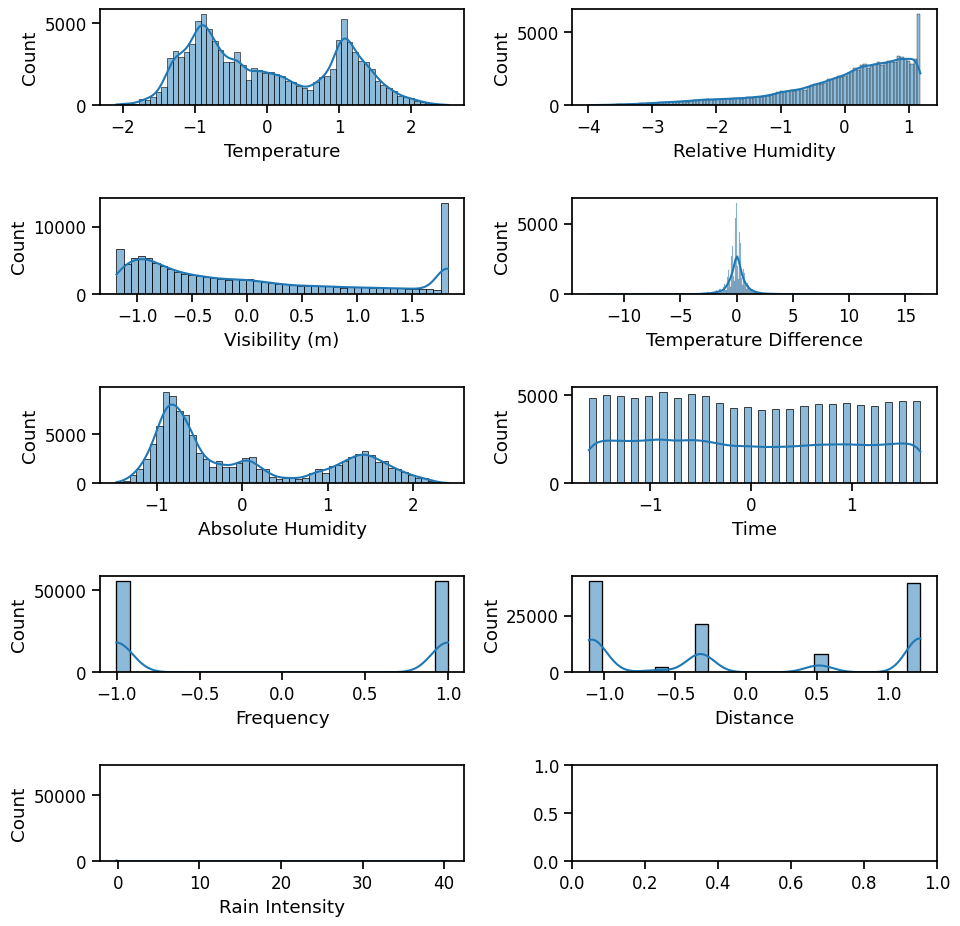

In [19]:
_X = df.drop('RFL_Att', axis=1)
_y = df['RFL_Att']
_clf = clf

# Fit the pipeline
_clf.fit(_X , _y)


# Get the transformed DataFrame
transformed_df = pd.DataFrame(_clf.named_steps['preprocessor'].transform(_X))

# Assign column names to the transformed DataFrame
transformed_df.columns = num_features + list(_clf.named_steps['preprocessor']
                                            .transformers_[1][1]['onehot'].get_feature_names_out(cat_features))

# Plot histograms of the scaled features
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
fig.tight_layout(pad=3.0)

for i, column in enumerate(transformed_df[num_features].columns):
    row = i // 2
    col = i % 2
    sns.histplot(data=transformed_df, x=column, kde=True, ax=axes[row, col])

plt.show()

## Split the data set into training and testing

In [20]:
# Separate features and target variable
X = df.drop('RFL_Att', axis=1)
y = df['RFL_Att']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Train and evaluate the model

In [ ]:
clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
y_pred = clf.predict(X_test)

# Calculate the evaluation metrics for the training data
print_metrics(y_train, train_predictions, 'TRAINING Original features untuned')
print_metrics(y_test, y_pred, 'TESTING Original features untuned')
save_metrics(y_test, y_pred, "original features untuned")

### Visualize the results

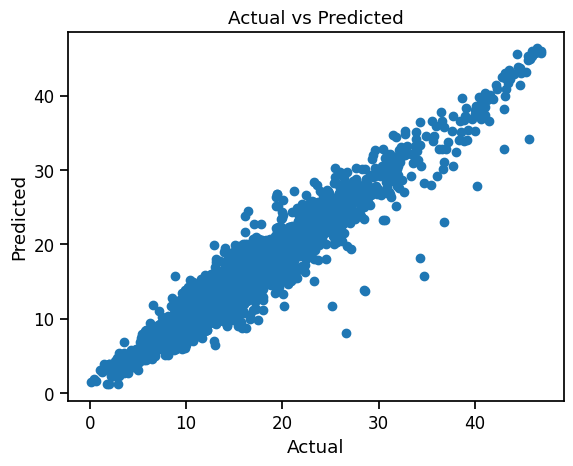

In [23]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

### Paramater tuning 

In [ ]:
from sklearn.model_selection import train_test_split

# X is your feature set and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [200,250],
    'max_depth': [None, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Initialize a Random Forest estimator
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Use the best model
best_rf = grid_search.best_estimator_

# Training and Testing performance
train_predict = best_rf.predict(X_train)
test_predict = best_rf.predict(X_test)


print_metrics(y_train, train_predict, 'TRAINING original features tuned')
print_metrics(y_test, test_predict, 'TESTING original features tuned')
save_metrics(y_test, test_predict, "original features tuned")


In [ ]:
print_metrics(y_train, train_predict, 'TRAINING')
print_metrics(y_test, test_predict, 'TESTING')

### Feature engineering

In [ ]:
# Feature engineering for the RF model

df_rf = df.copy()

df_rf['Time'] = pd.to_datetime(df_rf['Time'], unit='h')

# Create interaction features
df_rf['Temp_AbsHumid'] = df_rf['Temperature'] * df_rf['Absolute Humidity']
df_rf['Temp_RelHumid'] = df_rf['Temperature'] * df_rf['Relative Humidity']
df_rf['Temp_Diff_AbsHumid'] = df_rf['Temperature Difference'] * df_rf['Absolute Humidity']

# Create change rate features
df_rf['Temp_ChangeRate'] = df_rf['Temperature'].diff()
df_rf['Visib_ChangeRate'] = df_rf['Visibility (m)'].diff()


# Create a feature representing the elapsed time since the first observation
df_rf['Elapsed_Time'] = (df_rf['Time'] - df_rf['Time'].iloc[0]).dt.total_seconds() / 3600

# Create a feature representing the difference in time from the previous observation
df_rf['Time_Diff'] = df_rf['Elapsed_Time'].diff()

# Convert time back to int
df_rf['Time'] = df_rf['Time'].dt.hour

#drop hour column
df_rf = df_rf.drop('Hour', axis=1)

# Convert NaN values to a new category for categorical variables
df_rf['SYNOP Code'] = df_rf['SYNOP Code'].fillna('missing').astype(str)

# Define the features to create polynomials of
poly_features = ['Temperature', 'Visibility (m)',
                 'Frequency', 'Distance']

# Initialize PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform the polynomial features
poly_array = poly_transformer.fit_transform(df_rf[poly_features])

# Convert the array to a DataFrame
poly_df = pd.DataFrame(poly_array, columns=poly_transformer.get_feature_names_out(poly_features))

# Concatenate the polynomial features to the original DataFrame
df_rf = pd.concat([df_rf, poly_df], axis=1)

# Convert NaN values to a new category for categorical variables
df_rf['SYNOP Code'] = df_rf['SYNOP Code'].fillna('missing').astype(str)


# DROP DUPLICATE COLUMNS

df_rf = df_rf.iloc[:, [i for i in range(len(df_rf.columns)) if i not in [19,20,21,22,23,24,25,26]]]

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

cat_features = df_rf.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encode categorical features
df_rf_encoded = pd.get_dummies(df_rf, columns=cat_features)

# Now, update the list of numerical and categorical features
num_features = df_rf_encoded.select_dtypes(include='number').columns.tolist()
num_features = num_features[1:]
cat_features = df_rf_encoded.select_dtypes(exclude='number').columns.tolist()

# Separate features and target variable
X_rf = df_rf_encoded.drop('RFL_Att', axis=1)
y_rf = df_rf_encoded['RFL_Att']

# Split data into training and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size = 0.3, random_state = 42)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Create pipeline
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Fit the data
clf_rf.fit(X_train_rf, y_train_rf)

y_test_pred_rf = clf_rf.predict(X_test_rf)

print_metrics(y_test_rf, y_test_pred_rf, 'TESTING all new features')
save_metrics(y_test_rf, y_test_pred_rf, "all new features")

In [ ]:
# Check feature importances and remove those with importance 0.0
preprocessor.fit(X_train_rf, y_train_rf)
### Get feature names of numerical variables
num_features_names = preprocessor.transformers_[0][2]
### Get the feature of categorical variables
cat_features_names = cat_features
### Combine the feature names
feature_names = np.concatenate([num_features_names, cat_features_names])
# Get the importances of features
importances = clf_rf.named_steps['classifier'].feature_importances_

# Create a mask for features with importance > 0.0 and > 0.01
mask_0_01 = importances > 0.01
mask_0_02 = importances > 0.02


# Get the names of important features
important_features_0_01 = feature_names[mask_0_01]
important_features_0_02 = feature_names[mask_0_02]

# # Select only important features from the dataframe
X_rf_imp_0_01 = X_rf[important_features_0_01]
X_rf_imp_0_02 = X_rf[important_features_0_02]



### *features > 0.01*

In [ ]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

cat_features = X_rf_imp_0_01.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encode categorical features
df_encoded = pd.get_dummies(X_rf_imp_0_01, columns=cat_features)

# Now, update the list of numerical and categorical features
num_features = df_encoded.select_dtypes(include='number').columns.tolist()
num_features = num_features[1:]
cat_features = df_encoded.select_dtypes(exclude='number').columns.tolist()

# Separate features and target variable
X_rf = df_rf_encoded.drop('RFL_Att', axis=1)
y_rf = df_rf_encoded['RFL_Att']

# Split data into training and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf_imp_0_01, y_rf, test_size = 0.3, random_state = 42)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Create pipeline
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Fit the data
clf_rf.fit(X_train_rf, y_train_rf)

y_test_pred_rf = clf_rf.predict(X_test_rf)

print_metrics(y_test_rf, y_test_pred_rf, 'TESTING Features above > 0.01')
save_metrics(y_test_rf, y_test_pred_rf, "Features above > 0.01")

### *features > 0.02*

In [ ]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

cat_features = X_rf_imp_0_01.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encode categorical features
df_encoded = pd.get_dummies(X_rf_imp_0_01, columns=cat_features)

# Now, update the list of numerical and categorical features
num_features = df_encoded.select_dtypes(include='number').columns.tolist()
num_features = num_features[1:]
cat_features = df_encoded.select_dtypes(exclude='number').columns.tolist()

# Separate features and target variable
X_rf = df_rf_encoded.drop('RFL_Att', axis=1)
y_rf = df_rf_encoded['RFL_Att']

# Split data into training and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf_imp_0_01, y_rf, test_size = 0.3, random_state = 42)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Create pipeline
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Fit the data
clf_rf.fit(X_train_rf, y_train_rf)

y_test_pred_rf = clf_rf.predict(X_test_rf)

print_metrics(y_test_rf, y_test_pred_rf, 'TESTING Features above > 0.02')
save_metrics(y_test_rf, y_test_pred_rf, "Features above > 0.02")

## *FEATURE IMPORTANC FOR BEST MODEL(ORIGINAL FEATURES TUNED)*

In [ ]:
# Convert NaN values to a new category for categorical variables
# Define a mapping from numerical categories to strings
SYNOP_mapping = {
    0: 'Clear',
    3: 'Dust Storm',
    4: 'Fog',
    5: 'Drizzle',
    6: 'Rain',
    7: 'Snow',
    8: 'Showers'
}


# Replace the numerical categories with strings
df['SYNOP Code'] = df['SYNOP Code'].map(SYNOP_mapping)




# Define preprocessor
num_features = ['Temperature', 'Relative Humidity', 'Visibility (m)',
       'Temperature Difference', 'Absolute Humidity', 'Time', 'Frequency',
       'Distance', 'Rain Intensity']

cat_features = ['SYNOP Code']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Append classifier to preprocessing pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Separate features and target variable
X = df.drop('FSO_Att', axis=1)
y = df['FSO_Att']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

clf.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
baseline_predictions = clf.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
baseline_r2 = r2_score(y_test, baseline_predictions)

# Get the feature names after one-hot encoding
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=cat_features))

# Add the numerical features
feature_names = num_features + onehot_columns

# Un-comment below code to perform feature analysis on all levels of SYNOP Code
# feature_scores = {}
# for feature in feature_names: 
#     X_test_permuted = X_test.copy()
#     
#     if feature.startswith("SYNOP Code"):
#         # If this is a one-hot encoded feature, permute all the related columns
#         for column in X_test.columns:
#             if column.startswith("SYNOP Code"):
#                 X_test_permuted[column] = np.random.permutation(X_test_permuted[column])
#     else:
#         X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature])
#     permuted_predictions = clf.predict(X_test_permuted)
#     rmse_permuted = np.sqrt(mean_squared_error(y_test, permuted_predictions))
#     r2_permuted = r2_score(y_test, permuted_predictions)
#     feature_scores[feature] = {'RMSE_Difference': rmse_permuted - baseline_rmse,
#                                 'R2_Difference': baseline_r2 - r2_permuted}

feature_scores = {}
for feature in X_test.columns:
    X_test_permuted = X_test.copy()
    X_test_permuted[feature] = np.random.permutation(X_test[feature])
    permuted_predictions = clf.predict(X_test_permuted)
    rmse_permuted = np.sqrt(mean_squared_error(y_test, permuted_predictions))
    r2_permuted = r2_score(y_test, permuted_predictions)
    feature_scores[feature] = {'RMSE_Difference': rmse_permuted - baseline_rmse,
                                'R2_Difference': baseline_r2 - r2_permuted}


importance_df = pd.DataFrame(feature_scores).T

print(importance_df)

In [ ]:
importance_df = importance_df.sort_values(by = 'RMSE_Difference', ascending=False)

sns.set_context("notebook", font_scale=1.3)
plt.figure(figsize=(15, 10))
sns.barplot(x='RMSE_Difference', y=importance_df.index, data=importance_df, color='b', label='RMSE Difference')
plt.xlabel('RMSE', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('RF Feature Importance based on RMSE with 1 SYNOP Code column', fontsize=20)
plt.show()

plt.figure(figsize=(15, 10))
sns.barplot(x='R2_Difference', y=importance_df.index, data=importance_df, color='g', label='R-squared Difference')
plt.xlabel('R-squared', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.title('Feature Importance based on R-squared', fontsize=20)
plt.show()


### *Combined bar and line chart for feature analysis*

In [ ]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10,6))

# Create the bar plot on the first y-axis
bar = sns.barplot(x=importance_df.index, y=importance_df['RMSE_Difference'], ax=ax1, palette='summer')

# Create a second y-axis
ax2 = ax1.twinx()

# Create the line plot on the second y-axis
sns.lineplot(x=importance_df.index, y=importance_df['R2_Difference'], ax=ax2, color='b')

# Set the labels
ax1.set_xlabel('Feature Name')
ax1.set_ylabel('RMSE Difference')
ax2.set_ylabel('R2 Difference')

# Rotate x-axis labels
bar.set_xticklabels(bar.get_xticklabels(), rotation=90)

plt.title("RF Feature analysis")
# Show the plot
plt.show()



## *Recursive Feature Elimination*

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from math import sqrt


# Instantiate the Random Forest Regressor
clf = RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2)

# Specify the scoring method, in this case, the mean squared error
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return sqrt(mse)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create the RFECV object
rfecv = RFECV(estimator=clf, step=1, cv=KFold(5), scoring=mse_scorer)

# Separate features and target variable
X = df.drop('RFL_Att', axis=1)
y = df['RFL_Att']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Fit the RFECV to the training data
rfecv.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestRegressor(max_features='sqrt', n_estimators=200,
                                      random_state=42),
      scoring=make_scorer(mean_squared_error, greater_is_better=False))

### *Plot displying recursive feature elmination*

In [ ]:
print(f"Optimal number of features: {rfecv.n_features_}")

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

print("Selected features:", selected_features)


plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (rmse)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), -rfecv.cv_results_['mean_test_score'])
plt.title("RF Recursive feature elimination")
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.show()


### *Final Model*

In [ ]:
# Define preprocessor
num_features = ['Temperature', 'Relative Humidity', 'Visibility (m)',
       'Temperature Difference', 'Absolute Humidity', 'Time', 'Frequency',
       'Distance', 'Rain Intensity'] 

cat_features = []

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Append classifier to preprocessing pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Separate features and target variable
X = df.drop('RFL_Att', axis=1)
y = df['RFL_Att']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

clf.fit(X_train, y_train)

# Compute metrics for the new model
predictions = clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("RMSE: ", rmse)
print("R-squared: ", r2)



